<a href="https://colab.research.google.com/github/yesufma/credi-trust-rag-chatbot/blob/main/CrediTrust_RAG_Complaint_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install dependencies
!pip install -q pandas matplotlib seaborn nltk
!git config --global user.name "yesufma"
!git config --global user.email "yesufmt@gmail.com"

# Import libraries and mount Google Drive

In [5]:
# Import libraries and mount Google Drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from google.colab import drive

# Initialize NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Mount Google Drive
drive.mount('/content/drive')

# Set plot style
sns.set_theme(style="whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


# Define data loading function

In [6]:
 # Define data loading function
def load_complaints(file_path, chunksize=100000):
    """Load large CSV file in chunks"""
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Load dataset
file_path = '/content/drive/MyDrive/complaints.csv'
df = load_complaints(file_path)
print(f"Total complaints loaded: {len(df)}")
df.head(2)

Total complaints loaded: 9609797


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688


# Initial EDA - Narrative presence

In [7]:
# Initial EDA - Narrative presence
n_total = len(df)
n_missing = df['Consumer complaint narrative'].isna().sum()
print(f"Total complaints: {n_total:,}")
print(f"Complaints with narratives: {n_total - n_missing:,} ({(n_total - n_missing)/n_total*100:.1f}%)")
print(f"Complaints without narratives: {n_missing:,} ({n_missing/n_total*100:.1f}%)")

Total complaints: 9,609,797
Complaints with narratives: 2,980,756 (31.0%)
Complaints without narratives: 6,629,041 (69.0%)


# Initial EDA - Product distribution (top 15)

/tmp/ipython-input-8-891127833.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=product_counts.values, y=product_counts.index, palette="Blues_d")


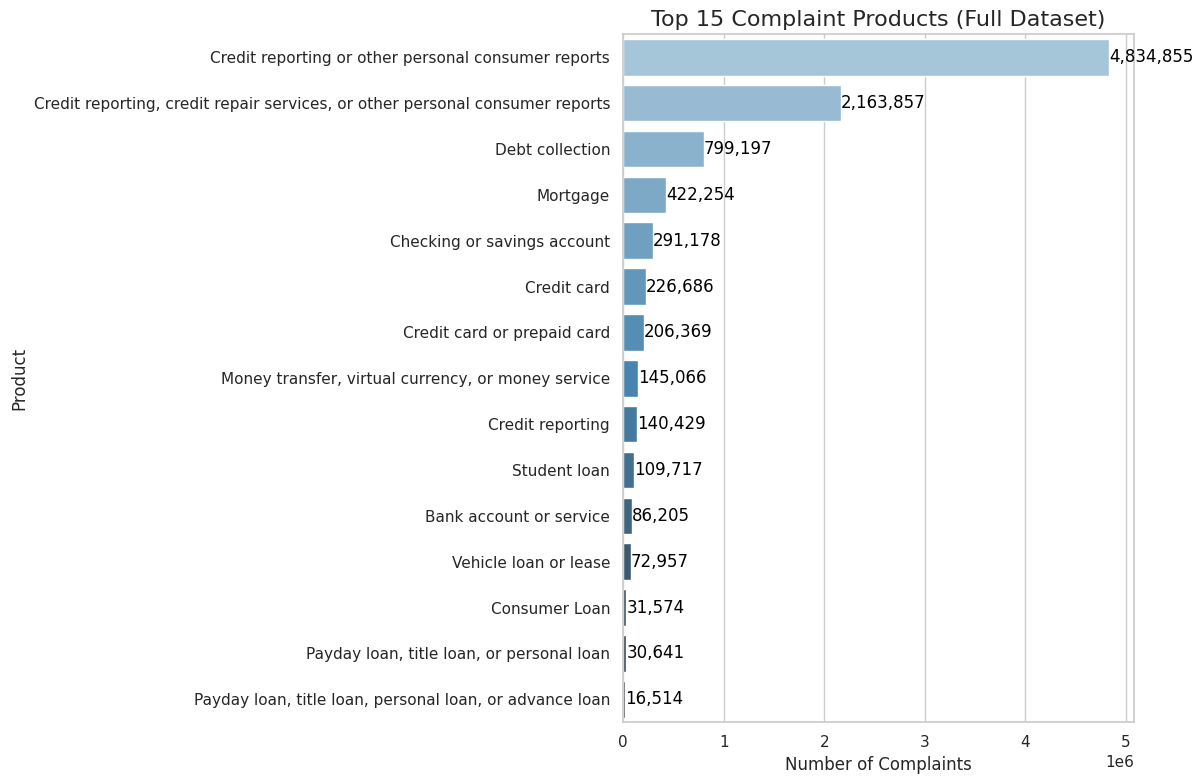

In [8]:
# Initial EDA - Product distribution (top 15)
plt.figure(figsize=(12, 8))
product_counts = df['Product'].value_counts().nlargest(15)
ax = sns.barplot(x=product_counts.values, y=product_counts.index, palette="Blues_d")
plt.title('Top 15 Complaint Products (Full Dataset)', fontsize=16)
plt.xlabel('Number of Complaints', fontsize=12)
plt.ylabel('Product', fontsize=12)

# Add value labels
for i, v in enumerate(product_counts.values):
    ax.text(v + 1000, i, f"{v:,}", color='black', va='center')

plt.tight_layout()
plt.show()

# Filter to required products

In [9]:
#  Filter to required products
# Define required products with mapping to dataset values
required_products = {
    'Credit card': 'Credit card',
    'Personal loan': 'Consumer Loan',  # Closest match
    'Buy Now, Pay Later (BNPL)': 'Payday loan',  # Closest match
    'Savings account': 'Checking or savings account',
    'Money transfers': 'Money transfer, virtual currency, or remittance'
}

# Filter to required products
df_filtered = df[df['Product'].isin(required_products.values())].copy()
print(f"Complaints after product filtering: {len(df_filtered)}")

# Remove records without narratives
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].notna()]
print(f"Complaints after removing empty narratives: {len(df_filtered)}")

# Map product names to standard values
reverse_product_map = {v: k for k, v in required_products.items()}
df_filtered['Product'] = df_filtered['Product'].map(reverse_product_map)

Complaints after product filtering: 554979
Complaints after removing empty narratives: 232193


/tmp/ipython-input-9-3119781536.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Product'] = df_filtered['Product'].map(reverse_product_map)


# Text cleaning function

In [10]:
# Text cleaning function
def clean_text(text):
    """Clean complaint narratives with advanced processing"""
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Remove common boilerplate
    text = re.sub(r'i am writing to (file|submit|make)?\s*(a)?\s*complaint( about)?', '', text)
    text = re.sub(r'this complaint is regarding', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [w for w in words if w not in stop_words and len(w) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]

    return ' '.join(words)

# Apply cleaning
df_filtered['clean_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

# Calculate word counts
df_filtered['word_count'] = df_filtered['clean_narrative'].apply(lambda x: len(x.split()))

# Show cleaned results
df_filtered[['Consumer complaint narrative', 'clean_narrative']].head(3)

,Consumer complaint narrative,clean_narrative
12237,A XXXX XXXX card was opened under my name by a...,xxxx xxxx card opened name fraudster received ...
12532,I made the mistake of using my wellsfargo debi...,made mistake using wellsfargo debit card depsi...
13280,"Dear CFPB, I have a secured credit card with c...",dear cfpb secured credit card citibank changed...


# Filtered data analysis - Product distribution

/tmp/ipython-input-11-3136336838.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=product_counts.values, y=product_counts.index, palette="viridis", order=product_counts.index)


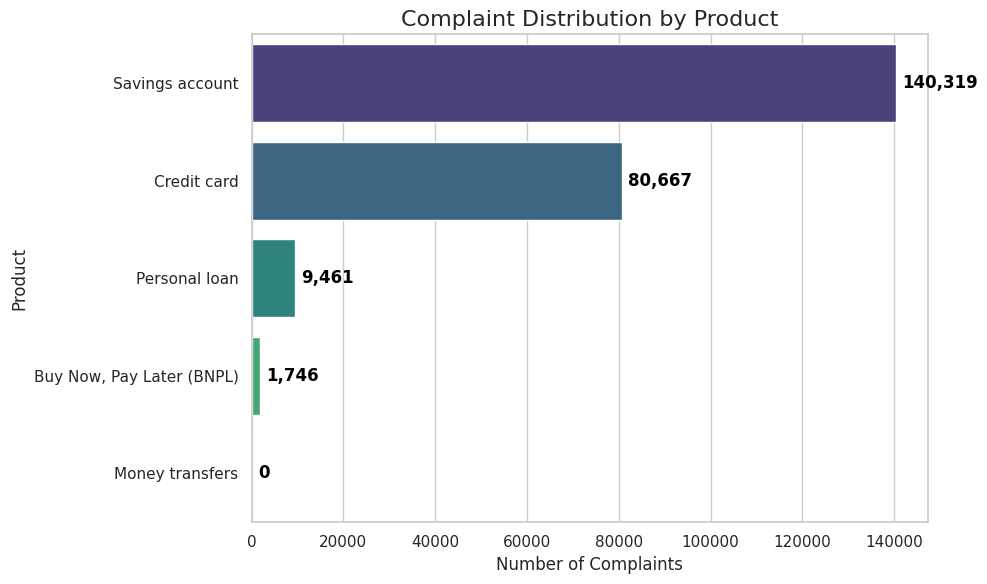


Complaint counts by product:
1. Savings account: 140,319 complaints
2. Credit card: 80,667 complaints
3. Personal loan: 9,461 complaints
4. Buy Now, Pay Later (BNPL): 1,746 complaints
5. Money transfers: 0 complaints


In [11]:
# Filtered data analysis - Product distribution (sorted by count)
# List of all required products
all_products = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)',
    'Savings account',
    'Money transfers'
]

# Get counts for existing products
existing_counts = df_filtered['Product'].value_counts()

# Create a complete series with all products, filling missing with 0
product_counts = pd.Series(index=all_products, data=0)
for product, count in existing_counts.items():
    if product in product_counts.index:
        product_counts[product] = count

# Sort products by count (largest at top)
product_counts = product_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=product_counts.values, y=product_counts.index, palette="viridis", order=product_counts.index)
plt.title('Complaint Distribution by Product', fontsize=16)
plt.xlabel('Number of Complaints', fontsize=12)
plt.ylabel('Product', fontsize=12)

# Add value labels
for i, v in enumerate(product_counts.values):
    ax.text(v + max(product_counts.values)*0.01, i, f"{v:,}", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print the counts for verification
print("\nComplaint counts by product:")
for i, (product, count) in enumerate(product_counts.items()):
    print(f"{i+1}. {product}: {count:,} complaints")

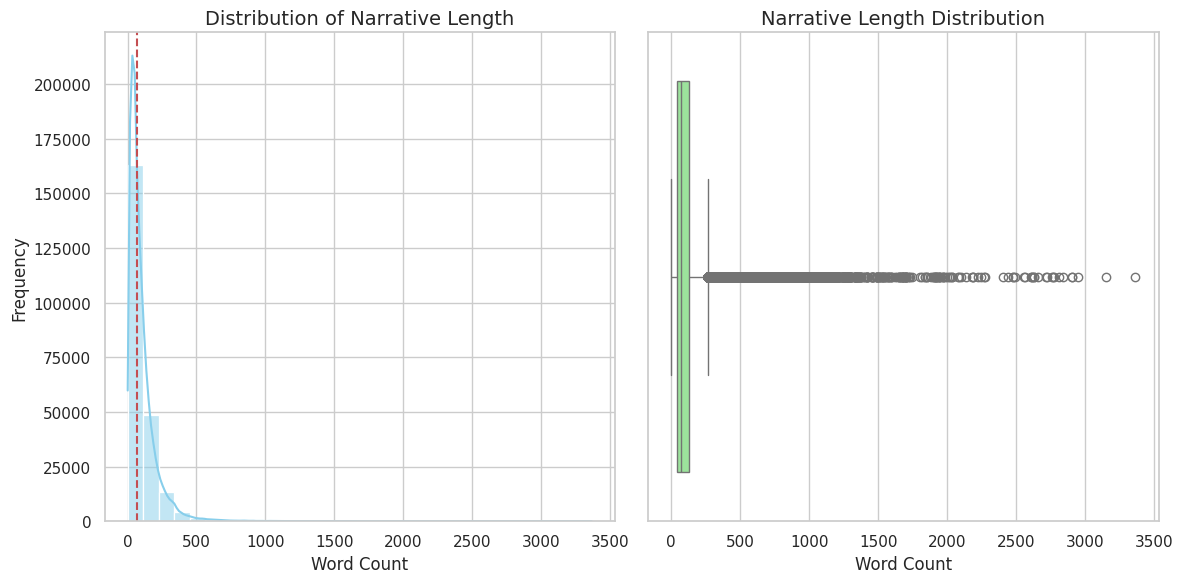


Narrative Length Statistics:
count    232193.000000
mean        102.181216
std         113.831052
min           1.000000
1%            7.000000
5%           13.000000
25%          38.000000
50%          71.000000
75%         128.000000
95%         291.000000
99%         522.000000
max        3366.000000
Name: word_count, dtype: float64


In [12]:
#  Filtered data analysis - Narrative length
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['word_count'], bins=30, kde=True, color="skyblue")
plt.axvline(df_filtered['word_count'].median(), color='r', linestyle='--')
plt.title('Distribution of Narrative Length', fontsize=14)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df_filtered['word_count'], color="lightgreen")
plt.title('Narrative Length Distribution', fontsize=14)
plt.xlabel('Word Count', fontsize=12)

plt.tight_layout()
plt.show()

# Calculate statistics
word_stats = df_filtered['word_count'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
print("\nNarrative Length Statistics:")
print(word_stats)

In [13]:
#  Identify short narratives
short_threshold = 5  # Words
short_narratives = df_filtered[df_filtered['word_count'] <= short_threshold]
print(f"\nNumber of very short narratives (≤{short_threshold} words): {len(short_narratives)}")

# Sample short narratives
if not short_narratives.empty:
    print("\nSample short narratives:")
    for i, row in short_narratives.sample(min(3, len(short_narratives))).iterrows():
        print(f"- Product: {row['Product']}")
        print(f"  Original: {row['Consumer complaint narrative'][:150]}...")
        print(f"  Cleaned: {row['clean_narrative']}")


Number of very short narratives (≤5 words): 1408

Sample short narratives:
- Product: Credit card
  Original: amount {$530.00} opened on XX/XX/year>...
  Cleaned: amount opened year
- Product: Savings account
  Original: Lots of unnecessary fees charged...
  Cleaned: lot unnecessary fee charged
- Product: Savings account
  Original: XX/XX/1989 I opened an account and never used it....
  Cleaned: opened account never used


In [14]:
# Save processed data
# Save to Google Drive
output_path = '/content/drive/MyDrive/filtered_complaints.csv'
df_filtered.to_csv(output_path, index=False)
print(f"\nSaved filtered data to: {output_path}")

# Save to project data directory
os.makedirs('../data', exist_ok=True)
project_data_path = '../data/filtered_complaints.csv'
df_filtered.to_csv(project_data_path, index=False)
print(f"Saved filtered data to project directory: {project_data_path}")

# Verify file exists
print("\nFiles in data directory:")
!ls -lh ../data


Saved filtered data to: /content/drive/MyDrive/filtered_complaints.csv
Saved filtered data to project directory: ../data/filtered_complaints.csv

Files in data directory:
total 478M
-rw-r--r-- 1 root root 478M Jul 10 11:30 filtered_complaints.csv


# Task 2

In [55]:
# 📦 Install dependencies (run once)
!pip install -q langchain-huggingface langchain-community sentence-transformers faiss-cpu

# Import libraries
import pandas as pd
import numpy as np
import os
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
import time

# Load only a sample of complaints for faster processing
df = pd.read_csv('../data/filtered_complaints.csv').head(20000)  # Sample size here
print(f"Loaded {len(df)} complaints (sample)")

# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]
)

# Chunk texts and prepare metadata
documents, metadatas = [], []
for _, row in df.iterrows():
    chunks = text_splitter.split_text(row['clean_narrative'])
    for chunk in chunks:
        documents.append(chunk)
        metadatas.append({
            "complaint_id": row.get("Complaint ID", None),
            "product": row["Product"],
            "word_count": len(chunk.split())
        })

print(f"Created {len(documents)} chunks from {len(df)} complaints")
print(f"Average chunks per complaint: {len(documents)/len(df):.2f}")

# Initialize embeddings (use GPU)
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},  # GPU device
    encode_kwargs={'normalize_embeddings': True}
)

# Batch processing to monitor progress
batch_size = 10000
batched_documents = [documents[i:i+batch_size] for i in range(0, len(documents), batch_size)]
batched_metadatas = [metadatas[i:i+batch_size] for i in range(0, len(metadatas), batch_size)]

vector_store = None

for i, (docs, metas) in enumerate(zip(batched_documents, batched_metadatas)):
    print(f"\n📦 Processing batch {i+1}/{len(batched_documents)}... ({len(docs)} chunks)")
    start = time.time()
    batch_vs = FAISS.from_texts(texts=docs, embedding=embeddings, metadatas=metas)
    print(f"⏱️ Batch {i+1} took {(time.time() - start)/60:.2f} minutes")

    if vector_store is None:
        vector_store = batch_vs
    else:
        vector_store.merge_from(batch_vs)

# Save vector store to Google Drive
vector_store_path = "/content/drive/MyDrive/vector_store/faiss_index_sample"
os.makedirs(vector_store_path, exist_ok=True)
vector_store.save_local(vector_store_path)

print(f"\n✅ Sample vector store saved to: {vector_store_path}")
print(f"Total vectors in index: {vector_store.index.ntotal}")


Loaded 20000 complaints (sample)
Created 39664 chunks from 20000 complaints
Average chunks per complaint: 1.98

📦 Processing batch 1/4... (10000 chunks)
⏱️ Batch 1 took 0.17 minutes

📦 Processing batch 2/4... (10000 chunks)
⏱️ Batch 2 took 0.16 minutes

📦 Processing batch 3/4... (10000 chunks)
⏱️ Batch 3 took 0.17 minutes

📦 Processing batch 4/4... (9664 chunks)
⏱️ Batch 4 took 0.18 minutes

✅ Sample vector store saved to: /content/drive/MyDrive/vector_store/faiss_index_sample
Total vectors in index: 39664


# Task 3

In [57]:
!pip install -q langchain-huggingface langchain-community sentence-transformers faiss-cpu transformers accelerate

from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import pipeline
import pandas as pd
import torch


In [58]:
# Define Retriever class
class ComplaintRetriever:
    def __init__(self, vector_store_path, model_name="sentence-transformers/all-MiniLM-L6-v2", device="cuda" if torch.cuda.is_available() else "cpu"):
        self.embeddings = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs={'device': device},
            encode_kwargs={'normalize_embeddings': True}
        )
        self.db = FAISS.load_local(vector_store_path, self.embeddings, allow_dangerous_deserialization=True)


    def retrieve(self, query, top_k=5):
        results = self.db.similarity_search(query, k=top_k)
        return results


In [59]:
class ComplaintAnswerGenerator:
    def __init__(self, model_name="google/flan-t5-base"):
        self.pipe = pipeline("text2text-generation", model=model_name, device=0 if torch.cuda.is_available() else -1)

    def format_prompt(self, context_chunks, question):
        context_text = "\n\n".join(context_chunks)
        return f"""You are a financial analyst assistant for CrediTrust. Your task is to answer questions about customer complaints.
Use the following retrieved complaint excerpts to formulate your answer. If the context doesn't contain the answer, state that you don't have enough information.

Context:
{context_text}

Question: {question}
Answer:"""

    def generate_answer(self, context_chunks, question):
        prompt = self.format_prompt(context_chunks, question)
        output = self.pipe(prompt, max_new_tokens=256)[0]["generated_text"]
        return output.strip()


In [60]:
class RAGPipeline:
    def __init__(self, vector_store_path):
        self.retriever = ComplaintRetriever(vector_store_path)
        self.generator = ComplaintAnswerGenerator()

    def answer_question(self, question, top_k=5):
        results = self.retriever.retrieve(question, top_k)
        chunks = [res.page_content for res in results]
        metadata = [res.metadata for res in results]
        answer = self.generator.generate_answer(chunks, question)
        return {
            "question": question,
            "answer": answer,
            "sources": chunks[:2],
            "metadata": metadata[:2]
        }


In [70]:
# Install transformers (only once)
!pip install -q transformers

# Imports
import pandas as pd
from transformers import pipeline

# Initialize summarizer
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Define summarization function
def summarize_answer(text):
    if not text.strip():
        return ""
    summary = summarizer(text, max_length=150, min_length=50, do_sample=False)
    return summary[0]['summary_text']

# Initialize RAG pipeline
vector_store_path = "/content/drive/MyDrive/vector_store/faiss_index_sample"
rag = RAGPipeline(vector_store_path)

# Define evaluation questions
questions = [
    "Why was my credit card payment rejected?",
    "How do I dispute a charge from a BNPL provider?",
    "What are common issues with money transfers?",
    "Why was my personal loan denied?",
    "How long does it take to get a savings account refund?"
]

# Run evaluation and summarize answers
results = []
for question in questions:
    response = rag.answer_question(question)
    summarized = summarize_answer(response['answer'])

    results.append({
        "Question": question,
        "Generated Answer": summarized,
        "Source Excerpts": "\n---\n".join(response['sources']),
        "Quality Score (1-5)": "",  # Fill manually
        "Comments": ""              # Fill manually
    })

# Create DataFrame
eval_df = pd.DataFrame(results)
eval_df


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 115. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)
Your max_length is set to 150, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)
Your max_length is set to 150, but your input_length is only 110. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 150, but your input_length is only 116. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length m

,Question,Generated Answer,Source Excerpts,Quality Score (1-5),Comments
0,Why was my credit card payment rejected?,Late payment credit card even though money ac...,tried paying discover credit card xxxx time xx...,,
1,How do I dispute a charge from a BNPL provider?,Bankers speak bank speak bank confirm bank co...,unauthorized charge removed due winning disput...,,
2,What are common issues with money transfers?,Money sent deposited transferred lost used us...,several occasion sending receiving money probl...,,
3,Why was my personal loan denied?,Credit denial happened year applied personal ...,applied loan denied due application submitted ...,,
4,How long does it take to get a savings account...,Day of the day is the 24th anniversary of the...,waiting fund account returned since year told ...,,


In [62]:
# Save to markdown format
with open("evaluation_table.md", "w") as f:
    f.write(eval_df.to_markdown(index=False))
print("✅ Evaluation table saved to evaluation_table.md")


✅ Evaluation table saved to evaluation_table.md


# Task 4

In [38]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.3 MB/s eta 0:00:00


In [78]:
%%writefile app.py
import streamlit as st
import torch
from transformers import pipeline
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# --- Class: Retriever ---
class ComplaintRetriever:
    def __init__(self, vector_store_path, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.embeddings = HuggingFaceEmbeddings(
            model_name=model_name,
            model_kwargs={"device": device},
            encode_kwargs={"normalize_embeddings": True}
        )
        self.db = FAISS.load_local(
            vector_store_path,
            self.embeddings,
            allow_dangerous_deserialization=True
        )

    def retrieve(self, query, top_k=5):
        return self.db.similarity_search(query, k=top_k)

# --- Class: Generator ---
class ComplaintAnswerGenerator:
    def __init__(self, model_name="google/flan-t5-base"):
        device = 0 if torch.cuda.is_available() else -1
        self.pipe = pipeline("text2text-generation", model=model_name, device=device)

    def format_prompt(self, context_chunks, question):
        context_text = "\n\n".join(context_chunks)
        return (
            "You are a financial analyst assistant for CrediTrust. "
            "Use the following retrieved complaint excerpts to answer the question. "
            "If the context doesn't contain the answer, say you don't have enough information.\n\n"
            f"Context:\n{context_text}\n\n"
            f"Question: {question}\nAnswer:"
        )

    def generate_answer(self, context_chunks, question):
        prompt = self.format_prompt(context_chunks, question)
        output = self.pipe(prompt, max_new_tokens=256)[0]["generated_text"]
        return output.strip()

# --- Summarizer ---
@st.cache_resource
def get_summarizer():
    return pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

def summarize_answer(text):
    summarizer = get_summarizer()
    summary = summarizer(text, max_length=120, min_length=40, do_sample=False)
    return summary[0]['summary_text']

# --- RAG Pipeline ---
class RAGPipeline:
    def __init__(self, vector_store_path):
        self.retriever = ComplaintRetriever(vector_store_path)
        self.generator = ComplaintAnswerGenerator()

    def ask(self, question):
        retrieved_chunks = self.retriever.retrieve(question, top_k=5)
        context_chunks = [doc.page_content for doc in retrieved_chunks]
        answer = self.generator.generate_answer(context_chunks, question)
        return answer, context_chunks

# --- Streamlit App ---
st.set_page_config(page_title="CrediTrust Complaint Chatbot", layout="centered")
st.title("🤖 CrediTrust Complaint Chatbot")
st.caption("Retrieve and answer customer complaint queries.")

VECTOR_STORE_PATH = "/content/drive/MyDrive/vector_store/faiss_index_sample"

if "rag" not in st.session_state:
    with st.spinner("🔄 Loading model and vector store..."):
        st.session_state.rag = RAGPipeline(VECTOR_STORE_PATH)

question = st.text_input("💬 Ask a question about customer complaints:")

if st.button("📤 Submit") and question.strip():
    with st.spinner("🔍 Retrieving and answering..."):
        answer, sources = st.session_state.rag.ask(question)
        summarized = summarize_answer(answer)

    st.success("✅ Summarized Answer")
    st.markdown(f"**{summarized}**")

    with st.expander("📚 Show Retrieved Sources"):
        for i, src in enumerate(sources, 1):
            st.markdown(f"**Source {i}:** {src[:500]}{'...' if len(src) > 500 else ''}")

if st.button("♻️ Clear"):
    st.experimental_rerun()


Overwriting app.py


In [73]:
!pip install streamlit transformers langchain langchain-huggingface langchain-community faiss-cpu


In [1]:
!nohup streamlit run app.py --server.port 8501 --server.headless true &
from pyngrok import ngrok
ngrok.set_auth_token("2xZlUxfhFUbZzDsSJ2KAvpeFMB2_2xFk4C4wUXP8mVkPtH3ci")
print(f"Streamlit public URL: {public_url}")


nohup: appending output to 'nohup.out'
Streamlit public URL: NgrokTunnel: "https://edf778d068e1.ngrok-free.app" -> "http://localhost:8501"
